In [1]:
import os

import openml
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
import pandas as pd 
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessRegressor
import plotly.express as px
import matplotlib.pyplot as plt
import json
from joblib import dump, load

import category_encoders as ce
import pygmo as pg

# Random forest as a black-box function
from black_box import RF_experiment, random_sample, psd_sample
from surrogate.custom_gp_kernel import KERNEL_GPML

In [2]:
os.path.abspath('.')

'/home/valavanca/Documents/hal/Diploma/src'

In [6]:
with open('./randomforest-search-space.json', 'r') as File:
    desc = json.loads(File.read())

bounds = []
# kv_desc = {p['name']: p for p in desc}
for param in desc:
    if 'categories' in param:
        bounds.append(list(range(1, len(param['categories'])+1)))
    else:
        bounds.append(param['bounds'])

list(zip(*bounds))

[(1, 2, 0.0, 0.0, 0.0, 1, 10), (2, 120, 1.0, 0.5, 0.5, 2, 1000)]

In [11]:
desc[1]

{'name': 'max_depth', 'type': 'integer', 'bounds': [2, 120], 'default': 50}

In [12]:
dict((k, desc[1][k]) for k in ('type', 'default'))

{'type': 'integer', 'default': 50}

In [6]:
prob.get_results()

AttributeError: 'pygmo.core.problem' object has no attribute 'get_results'

In [8]:
DATA_SET = 1049

class RFProblem():

    def __init__(self, dataset_num):
        
        path = os.path.abspath('.')
        # --- describtion of random-forest(RF) parameters
        with open(path + '/randomforest-search-space.json', 'r') as File:
            params_description = json.loads(File.read())
        self._encoder = load(path + '/encoder.joblib')

        # DATA-SET
        # --- get evaluation dataset
        dataset = openml.datasets.get_dataset(dataset_num)
        X, y, cat, atr = dataset.get_data(
            dataset_format="array",
            target=dataset.default_target_attribute)

        # --- scale samples
        X = pd.DataFrame(X, columns=atr)
        ct = make_column_transformer(
            (StandardScaler(), make_column_selector(dtype_include=np.number)))
        X = pd.DataFrame(ct.fit_transform(X), columns=atr)

        self.X = X.values
        self.y = y

    def fitness(self, x):
        PARAMS = ['min_samples_split', 'min_samples_leaf', 'min_weight_fraction_leaf',
                  'criterion', 'max_depth', 'max_features', 'n_estimators']
        x_enc = self._encoder.inverse_transform(
            pd.DataFrame([x], columns=PARAMS))
        x_enc['n_estimators'] = x_enc['n_estimators'].astype('int32')
        param = x_enc.iloc[0].to_dict()

        

        clf = RandomForestClassifier(**param)
        scores = cross_validate(clf,
                                self.X,
                                self.y,
                                scoring=["f1", "roc_auc"],
                                cv=3)

        for k, v in scores.items():
            scores[k] = np.mean(v)

        return [scores[obj] for obj in ['test_roc_auc', 'fit_time']]

    def get_results(self):
        return self.results_df

    def get_nobj(self):
        return 2

    # Return bounds of decision variables
    def get_bounds(self):
        return ([0.0, 0.0, 0.0, 1.0, 2.0, 1.0, 10.0],
                [1.0e+00, 5.0e-01, 5.0e-01, 2.0e+00, 1.2e+02, 2.0e+00, 1.0e+03])

    # Integer Dimension
    def get_nix(self):
        return 4

    def gradient(self, x):
        return pg.estimate_gradient_h(lambda x: self.fitness(x), x)

    # Return function name
    def get_name(self):
        return "NSGA2 on RandomForestClassifier"
    
prob = pg.problem(RFProblem(DATA_SET))


# pop = pg.population(prob=prob, size=20)
# final_pop = pg.algorithm(pg.nsga2(gen = 10)).evolve(pop)


isl = pg.island(algo=pg.nsga2(gen=10),
                size=20,
                prob=prob,
                udi=pg.mp_island(),
                )
isl.evolve()
isl.wait()
final_pop = isl.get_population()
# idx = pg.fast_non_dominated_sorting(isl.get_population().get_f())[0][0]

final_pop

Problem name: NSGA2 on RandomForestClassifier
	C++ class name: pybind11::object

	Global dimension:			7
	Integer dimension:			4
	Fitness dimension:			2
	Number of objectives:			2
	Equality constraints dimension:		0
	Inequality constraints dimension:	0
	Lower bounds: [0, 0, 0, 1, 2, ... ]
	Upper bounds: [1, 0.5, 0.5, 2, 120, ... ]
	Has batch fitness evaluation: false

	Has gradient: true
	User implemented gradient sparsity: false
	Expected gradients: 14
	Has hessians: false
	User implemented hessians sparsity: false

	Fitness evaluations: 220
	Gradient evaluations: 0

	Thread safety: none

Population size: 20

List of individuals: 
#0:
	ID:			14458784842667483397
	Decision vector:	[0.696415, 0.139708, 0.384556, 1, 99, ... ]
	Fitness vector:		[0.5, 0.0244979]
#1:
	ID:			12649272187910216441
	Decision vector:	[0.852705, 0.3943, 0.418585, 2, 99, ... ]
	Fitness vector:		[0.5, 0.0248077]
#2:
	ID:			17929410209493335694
	Decision vector:	[0.852705, 0.401436, 0.418585, 1, 99, ... ]
	Fitness ve

In [32]:
columns = ['criterion', 'max_depth', 'min_samples_split', 'min_samples_leaf', 'min_weight_fraction_leaf', 'max_features', 'n_estimators']
x = [4.45424383e-02, 4.99429627e-01, 2.29817779e-01, 1.00000000e+00, 4.80000000e+01, 2.00000000e+00, 5.90000000e+01]
ec = load('./encoder.joblib') 
# ec.inverse_transform([x])

ec.inverse_transform(pd.DataFrame([x], columns=columns))

,criterion,max_depth,min_samples_split,min_samples_leaf,min_weight_fraction_leaf,max_features,n_estimators
0,NaN,0.49943,0.229818,1.0,48.0,log2,59.0


## Initialization
- read search-space for the random forest (black box function)
- open evaluation dataset for the random forest

### Dataset information:
- [OpenMl 1049](https://www.openml.org/d/1049)
- PC4 Software defect prediction
One of the NASA Metrics Data Program defect data sets. Data from flight software for earth orbiting satellite. Data comes from McCabe and Halstead features extractors of source code. These features were defined in the 70s in an attempt to objectively characterize code features that are associated with software quality.

In [3]:
# --- open dataset
#  dataset has only numerical features
dataset = openml.datasets.get_dataset(1049)
X, y, cat, atr = dataset.get_data(dataset_format="array", target=dataset.default_target_attribute)

X = pd.DataFrame(X, columns=atr)
y = pd.DataFrame(y, columns=['defect'])

# --- transform 
ct = make_column_transformer((StandardScaler(), make_column_selector(dtype_include=np.number)))
X = pd.DataFrame(ct.fit_transform(X), columns=atr)

## Black box function: Random forest classification on dataset 

In [4]:
# --- red search space
with open('./randomforest-search-space.json', 'r') as File:
        sp = json.loads(File.read())
sp

[{'name': 'criterion',
  'type': 'category',
  'categories': ['gini', 'entropy'],
  'default': 'gini'},
 {'name': 'max_depth', 'type': 'integer', 'bounds': [2, 120], 'default': 50},
 {'name': 'min_samples_split',
  'type': 'float',
  'bounds': [0.0, 1.0],
  'default': 0.1},
 {'name': 'min_samples_leaf',
  'type': 'float',
  'bounds': [0.0, 0.5],
  'default': 0.1},
 {'name': 'min_weight_fraction_leaf',
  'type': 'float',
  'bounds': [0.0, 0.5],
  'default': 0.0},
 {'name': 'max_features',
  'type': 'category',
  'categories': ['sqrt', 'log2'],
  'default': 'sqrt'},
 {'name': 'n_estimators',
  'type': 'integer',
  'bounds': [10, 1000],
  'default': 100}]

In [5]:
samples_X = psd_sample(sp, 10, kind='sobol')
samples_X

,criterion,max_depth,min_samples_split,min_samples_leaf,min_weight_fraction_leaf,max_features,n_estimators
0,gini,61,0.5000,0.25000,0.25000,sqrt,505
1,entropy,31,0.7500,0.12500,0.37500,sqrt,752
2,gini,90,0.2500,0.37500,0.12500,log2,257
3,gini,46,0.6250,0.06250,0.43750,log2,133
4,entropy,105,0.1250,0.31250,0.18750,sqrt,628
5,entropy,16,0.3750,0.18750,0.06250,log2,876
6,gini,75,0.8750,0.43750,0.31250,sqrt,381
7,gini,38,0.3125,0.34375,0.28125,sqrt,71
8,entropy,97,0.8125,0.09375,0.03125,log2,566
9,entropy,9,0.5625,0.46875,0.15625,sqrt,814


In [6]:
samples_y = pd.DataFrame([RF_experiment(X, y, config) for idx, config in samples_X.iterrows()])
samples_y

,fit_time,score_time,test_f1_macro,test_f1_weighted,test_roc_auc
0,1.261039,0.171989,0.467494,0.820841,0.862699
1,1.757790,0.245959,0.467494,0.820841,0.500000
2,0.587620,0.093941,0.467494,0.820841,0.500000
3,0.258125,0.053695,0.467494,0.820841,0.847505
4,1.307383,0.195206,0.467494,0.820841,0.791686
5,1.889014,0.262949,0.467494,0.820841,0.873806
6,0.712105,0.158353,0.467494,0.820841,0.500000
7,0.138806,0.031831,0.467494,0.820841,0.500000
8,1.015811,0.132237,0.467494,0.820841,0.500000
9,1.495284,0.254359,0.467494,0.820841,0.500000


In [7]:
cat_columns = samples_X.select_dtypes(include=[object]).columns
ce_one_hot = ce.OrdinalEncoder(cols = cat_columns)
samples_X_enc = ce_one_hot.fit_transform(samples_X)
samples_X_enc.sort_index(axis=1, ascending=False, key=lambda x: samples_X_enc[x].dtypes, inplace=True)
samples_X_enc

/home/valavanca/anaconda3/envs/ml-env/lib/python3.7/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,min_samples_split,min_samples_leaf,min_weight_fraction_leaf,criterion,max_depth,max_features,n_estimators
0,0.5000,0.25000,0.25000,1,61,1,505
1,0.7500,0.12500,0.37500,2,31,1,752
2,0.2500,0.37500,0.12500,1,90,2,257
3,0.6250,0.06250,0.43750,1,46,2,133
4,0.1250,0.31250,0.18750,2,105,1,628
5,0.3750,0.18750,0.06250,2,16,2,876
6,0.8750,0.43750,0.31250,1,75,1,381
7,0.3125,0.34375,0.28125,1,38,1,71
8,0.8125,0.09375,0.03125,2,97,2,566
9,0.5625,0.46875,0.15625,2,9,1,814


In [8]:
gp = GaussianProcessRegressor(kernel=KERNEL_GPML)
gp.fit(samples_X_enc.to_numpy(), samples_y[['test_roc_auc', 'fit_time']].to_numpy())

GaussianProcessRegressor(kernel=66**2 * RBF(length_scale=67) + 2.4**2 * RBF(length_scale=90) * ExpSineSquared(length_scale=1.3, periodicity=1) + 0.66**2 * RationalQuadratic(alpha=0.78, length_scale=1.2) + 0.18**2 * RBF(length_scale=0.134) + WhiteKernel(noise_level=0.0361))

In [9]:
class PygmoProblem():

    def __init__(self,
                 surrogate,
                 bounds):
        self._surrogate = surrogate
        self._bounds = bounds

    def fitness(self, x):
        x = np.array(x)
        result = self._surrogate.predict(x.reshape(1, -1))
        return result.flatten().tolist()

    def get_nobj(self):
        prediction = self._surrogate.predict([self._bounds[0]])
        nobj = prediction.flatten().size
        return nobj

    # Return bounds of decision variables
    def get_bounds(self):
        return self._bounds
    
    # Integer Dimension
    def get_nix(self):
        return (samples_X_enc.dtypes==np.int64).sum() 
    
    def gradient(self, x):
        return pg.estimate_gradient_h(lambda x: self.fitness(x), x)
    
    # Return function name
    def get_name(self):
        meta_name = type(self._surrogate).__name__
        if hasattr(self._surrogate, 'estimators_'):
            return meta_name + ": " + " vs ".join([type(t).__name__ for t in self._surrogate.estimators_])
        else:
            return meta_name

# ((10, 10, 1, 1), (-10, -10, 0, 0))
def get_bounds(desc, enc_df):
    bounds = []
    kv_desc = { p['name']: p for p in desc}
    for col in enc_df.columns:
        if col in cat_columns:    
            bounds.append(list(range(1, len(kv_desc[col]['categories'])+1)))
        else:
            bounds.append(kv_desc[col]['bounds'])
            
    return list(zip(*bounds))

bounds = get_bounds(sp, samples_X_enc)        
prob = pg.problem(PygmoProblem(gp, bounds))
prob

Problem name: GaussianProcessRegressor
	C++ class name: pybind11::object

	Global dimension:			7
	Integer dimension:			4
	Fitness dimension:			2
	Number of objectives:			2
	Equality constraints dimension:		0
	Inequality constraints dimension:	0
	Lower bounds: [0, 0, 0, 1, 2, ... ]
	Upper bounds: [1, 0.5, 0.5, 2, 120, ... ]
	Has batch fitness evaluation: false

	Has gradient: true
	User implemented gradient sparsity: false
	Expected gradients: 14
	Has hessians: false
	User implemented hessians sparsity: false

	Fitness evaluations: 0
	Gradient evaluations: 0

	Thread safety: none

In [14]:
# archi = pg.archipelago(n = 100, algo = pg.nsga2(), prob = PygmoProblem(gp, bounds), pop_size=100)
# archi.evolve(2) 
# archi.wait()

pop = pg.population(prob=prob, size=100)
e_pop = pg.algorithm(pg.moead(gen = 100)).evolve(pop)
final_pop = pg.algorithm(pg.moead(gen = 100)).evolve(e_pop)


# isl = pg.island(algo=[pg.nsga2(gen=100), pg.nsga2(gen=200)],
#                 size=100,
#                 prob=prob,
#                 udi=pg.mp_island(),
#                 )
# isl.evolve()
# isl.wait()
# final_pop = isl.get_population()
# idx = pg.fast_non_dominated_sorting(isl.get_population().get_f())[0][0]

idx = pg.fast_non_dominated_sorting(e_pop.get_f())[0][0]

pop_df = pd.DataFrame(e_pop.get_x()[idx], columns=samples_X_enc.columns)
predict = ce_one_hot.inverse_transform(pop_df)
predict['n_estimators'] = predict['n_estimators'].astype('int32')
predict

,min_samples_split,min_samples_leaf,min_weight_fraction_leaf,criterion,max_depth,max_features,n_estimators
0,0.099779,0.476938,0.026857,NaN,118.355090,NaN,10
1,0.001980,0.408116,0.021908,NaN,118.325202,NaN,10
2,0.281895,0.359433,0.028651,NaN,118.327781,NaN,10
3,0.281895,0.359433,0.028651,NaN,118.327781,NaN,10
4,0.398102,0.370757,0.025978,NaN,118.310011,NaN,10
...,...,...,...,...,...,...,...
94,0.238719,0.417404,0.047711,NaN,82.002110,NaN,10
95,0.236444,0.398989,0.075426,NaN,82.003090,NaN,10
96,0.251737,0.414102,0.084595,NaN,82.000856,NaN,10
97,0.206597,0.465377,0.094462,NaN,82.002006,NaN,10


In [16]:
df = pd.read_pickle('./bench/separate(GaussianProcessRegressor+GaussianProcessRegressor)_2_RF.zy7hek.pkl')
df

,iteration,problem,objectives,feature_dim,ndf_size,ndf_f,ndf_x,i_time,model_id
0,1,separate(GaussianProcessRegressor+GaussianProc...,"[test_roc_auc, fit_time]",7,1,"[[0.5, 0.16062370936075845]]","[[gini, 11.0, 0.9074249842573411, 7.4834517627...",27.768566,139844412893552
1,2,separate(GaussianProcessRegressor+GaussianProc...,"[test_roc_auc, fit_time]",7,1,"[[0.5, 0.16062370936075845]]","[[gini, 11.0, 0.9074249842573411, 7.4834517627...",53.861493,139844412893552
2,3,separate(GaussianProcessRegressor+GaussianProc...,"[test_roc_auc, fit_time]",7,1,"[[0.5, 0.16062370936075845]]","[[gini, 11.0, 0.9074249842573411, 7.4834517627...",96.874480,139844412893552
3,4,separate(GaussianProcessRegressor+GaussianProc...,"[test_roc_auc, fit_time]",7,1,"[[0.5, 0.16062370936075845]]","[[gini, 11.0, 0.9074249842573411, 7.4834517627...",132.577953,139844412893552
4,5,separate(GaussianProcessRegressor+GaussianProc...,"[test_roc_auc, fit_time]",7,1,"[[0.5, 0.16062370936075845]]","[[gini, 11.0, 0.9074249842573411, 7.4834517627...",167.800150,139844412893552
5,6,separate(GaussianProcessRegressor+GaussianProc...,"[test_roc_auc, fit_time]",7,2,"[[0.5, 0.16062370936075845], [0.5, 0.141852617...","[[gini, 11.0, 0.9074249842573411, 7.4834517627...",198.833845,139844412893552
6,7,separate(GaussianProcessRegressor+GaussianProc...,"[test_roc_auc, fit_time]",7,2,"[[0.5, 0.16062370936075845], [0.5, 0.141852617...","[[gini, 11.0, 0.9074249842573411, 7.4834517627...",237.078687,139844412893552
7,8,separate(GaussianProcessRegressor+GaussianProc...,"[test_roc_auc, fit_time]",7,2,"[[0.5, 0.16062370936075845], [0.5, 0.141852617...","[[gini, 11.0, 0.9074249842573411, 7.4834517627...",267.142237,139844412893552
8,9,separate(GaussianProcessRegressor+GaussianProc...,"[test_roc_auc, fit_time]",7,3,"[[0.5, 0.16062370936075845], [0.5, 0.141852617...","[[gini, 11.0, 0.9074249842573411, 7.4834517627...",290.497768,139844412893552
9,10,separate(GaussianProcessRegressor+GaussianProc...,"[test_roc_auc, fit_time]",7,4,"[[0.5, 0.16062370936075845], [0.5, 0.141852617...","[[gini, 11.0, 0.9074249842573411, 7.4834517627...",315.165687,139844412893552


In [19]:
pd.read_pickle('./bench/dataset.zy7hek.pkl')

,criterion,max_depth,min_samples_split,min_samples_leaf,min_weight_fraction_leaf,max_features,n_estimators,fit_time,score_time,test_f1,test_roc_auc
0,gini,61.000000,5.000000e-01,2.500000e-01,0.250000,sqrt,505,1.867784,0.242659,0.000000,0.860019
1,entropy,31.000000,7.500000e-01,1.250000e-01,0.375000,sqrt,752,2.618322,0.388817,0.000000,0.500000
2,gini,90.000000,2.500000e-01,3.750000e-01,0.125000,log2,257,1.118356,0.113337,0.000000,0.500000
3,gini,46.000000,6.250000e-01,6.250000e-02,0.437500,log2,133,0.558473,0.085401,0.000000,0.838064
4,entropy,105.000000,1.250000e-01,3.125000e-01,0.187500,sqrt,628,2.242293,0.291249,0.000000,0.791520
5,entropy,16.000000,3.750000e-01,1.875000e-01,0.062500,log2,876,3.226000,0.430526,0.000000,0.874133
6,gini,75.000000,8.750000e-01,4.375000e-01,0.312500,sqrt,381,1.329587,0.162075,0.000000,0.500000
7,gini,38.000000,3.125000e-01,3.437500e-01,0.281250,sqrt,71,0.323588,0.062750,0.000000,0.500000
8,entropy,97.000000,8.125000e-01,9.375000e-02,0.031250,log2,566,2.065013,0.249505,0.000000,0.500000
9,entropy,9.000000,5.625000e-01,4.687500e-01,0.156250,sqrt,814,3.291096,0.399055,0.000000,0.500000


In [17]:
temp_df = pd.DataFrame.from_records(df.explode('ndf_f'))

ndf_f = pd.DataFrame.from_records(temp_df['ndf_f'].values, columns=temp_df.iloc[0]['objectives']) 
temp_df = pd.concat([temp_df.reset_index(drop=True), ndf_f], axis=1).drop('ndf_f', 1)
temp_df

,iteration,problem,objectives,feature_dim,ndf_size,ndf_x,i_time,model_id,test_roc_auc,fit_time
0,1,separate(GaussianProcessRegressor+GaussianProc...,"[test_roc_auc, fit_time]",7,1,"[[gini, 11.0, 0.9074249842573411, 7.4834517627...",27.768566,139844412893552,0.500000,0.160624
1,2,separate(GaussianProcessRegressor+GaussianProc...,"[test_roc_auc, fit_time]",7,1,"[[gini, 11.0, 0.9074249842573411, 7.4834517627...",53.861493,139844412893552,0.500000,0.160624
2,3,separate(GaussianProcessRegressor+GaussianProc...,"[test_roc_auc, fit_time]",7,1,"[[gini, 11.0, 0.9074249842573411, 7.4834517627...",96.874480,139844412893552,0.500000,0.160624
3,4,separate(GaussianProcessRegressor+GaussianProc...,"[test_roc_auc, fit_time]",7,1,"[[gini, 11.0, 0.9074249842573411, 7.4834517627...",132.577953,139844412893552,0.500000,0.160624
4,5,separate(GaussianProcessRegressor+GaussianProc...,"[test_roc_auc, fit_time]",7,1,"[[gini, 11.0, 0.9074249842573411, 7.4834517627...",167.800150,139844412893552,0.500000,0.160624
5,6,separate(GaussianProcessRegressor+GaussianProc...,"[test_roc_auc, fit_time]",7,2,"[[gini, 11.0, 0.9074249842573411, 7.4834517627...",198.833845,139844412893552,0.500000,0.160624
6,6,separate(GaussianProcessRegressor+GaussianProc...,"[test_roc_auc, fit_time]",7,2,"[[gini, 11.0, 0.9074249842573411, 7.4834517627...",198.833845,139844412893552,0.500000,0.141853
7,7,separate(GaussianProcessRegressor+GaussianProc...,"[test_roc_auc, fit_time]",7,2,"[[gini, 11.0, 0.9074249842573411, 7.4834517627...",237.078687,139844412893552,0.500000,0.160624
8,7,separate(GaussianProcessRegressor+GaussianProc...,"[test_roc_auc, fit_time]",7,2,"[[gini, 11.0, 0.9074249842573411, 7.4834517627...",237.078687,139844412893552,0.500000,0.141853
9,8,separate(GaussianProcessRegressor+GaussianProc...,"[test_roc_auc, fit_time]",7,2,"[[gini, 11.0, 0.9074249842573411, 7.4834517627...",267.142237,139844412893552,0.500000,0.160624


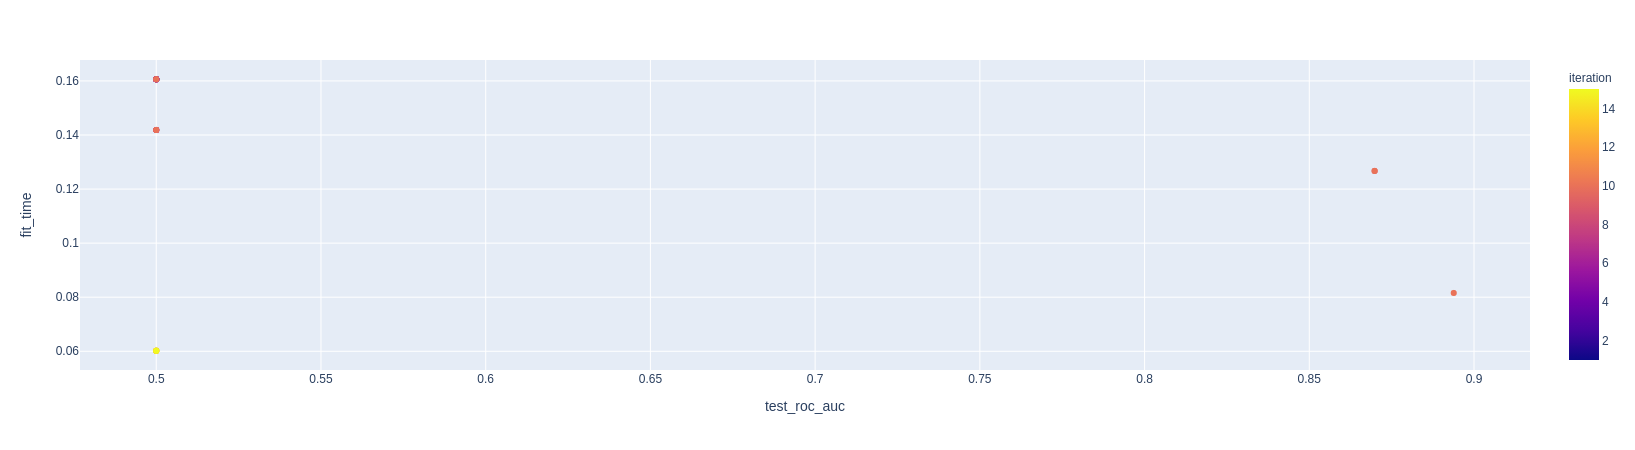

In [18]:
px.scatter(temp_df, x="test_roc_auc", y="fit_time", color="iteration")

In [26]:
ar = np.array([[1,1], [1, 0], [0,0], [0, 1]])* [1,-1]
idx = pg.fast_non_dominated_sorting(ar)[0][0]
ar[idx]

array([[ 0, -1]])

In [24]:
ar * [1,-1]

array([[ 1, -1],
       [ 1,  0],
       [ 0,  0],
       [ 0, -1]])